In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Users/jamesl/Workspace/titanic')
sns.set()

import data

# Reading the data
The first step will be to read in the data from data/raw/train.csv into a pandas dataframe. 

In [2]:
train = pd.read_csv('data/raw/train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Looking for Missing Data and Taking a First Look
Next I will look for any missing data that we may have. Since most of the cabin information is missing, I may want to consider dropping that column. However, the letter infront of the cabin number indicates what deck someone was on in the titanic. I belive there may be a strong correlation between deck and survival and fare. However, I will explore that later. 

In [4]:
data.find_missing_values(train)

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [5]:
train['Name'].sample(n=20)

116                              Connors, Mr. Patrick
132    Robins, Mrs. Alexander A (Grace Charity Laury)
696                                  Kelly, Mr. James
730                     Allen, Miss. Elisabeth Walton
791                               Gaskell, Mr. Alfred
413                    Cunningham, Mr. Alfred Fleming
676                     Sawyer, Mr. Frederick Charles
653                     O'Leary, Miss. Hanora "Norah"
406                  Widegren, Mr. Carl/Charles Peter
245                       Minahan, Dr. William Edward
619                               Gavey, Mr. Lawrence
274                        Healy, Miss. Hanora "Nora"
118                          Baxter, Mr. Quigg Edmond
102                         White, Mr. Richard Frasar
544                        Douglas, Mr. Walter Donald
87                      Slocovski, Mr. Selman Francis
588                             Gilinski, Mr. Eliezer
500                                  Calic, Mr. Petar
35                     Holve

Every passenger seems to have a title attached to them. Next I will make a separate column containing their titles. Titles like mlle and mme are just french equivalents if ms. There are several titles such as Major or Captain that are rare so we can move all of those into their own rare title class. 

In [6]:
train['Title'] = data.find_title(train)

In [7]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt.,0,1
Col.,0,2
Countess.,1,0
Don.,0,1
Dr.,1,6
Jonkheer.,0,1
Lady.,1,0
Major.,0,2
Master.,0,40


In [8]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked,Title
count,891,891,891,204,889,891
unique,891,2,681,147,3,17
top,"Bowen, Mr. David John ""Dai""",male,1601,C23 C25 C27,S,Mr.
freq,1,577,7,4,644,517


In [9]:
train[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


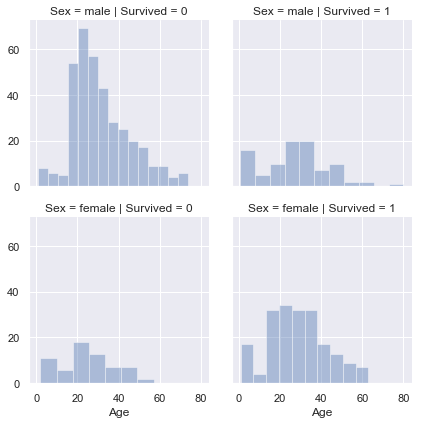

In [10]:
g = sns.FacetGrid(train, col='Survived', row='Sex')
g.map(sns.distplot, 'Age', kde=False)

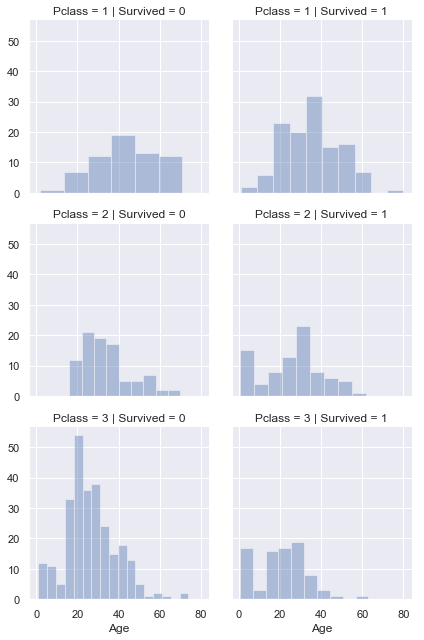

In [11]:
h = sns.FacetGrid(train, col='Survived', row='Pclass')
h.map(sns.distplot, 'Age', kde=False)